# Forecasting Models Comparison

This notebook demonstrates and compares multiple forecasting approaches: baseline Prophet, standalone NeuralProphet, and ensemble methods combining frequency decomposition with different models.

**Approaches demonstrated:**
1. **Baseline Prophet** - Single Prophet on raw signal
2. **Standalone NeuralProphet** - NeuralProphet with autoregressive components
3. **Dual Prophet (sum)** - High-freq + Low-freq Prophet with bias correction
4. **Dual Prophet (weighted)** - Weighted frequency decomposition
5. **Dual NeuralProphet** - Same setup with NeuralProphet models

In [1]:
from __future__ import annotations

import warnings
warnings.filterwarnings("ignore")

import logging
logging.disable(logging.INFO)

# Performance optimization: limit threading to reduce CPU usage and thermal throttling
# Also suppress Intel MKL duplicate library warnings
import os
# os.environ["KMP_NUM_THREADS"] = "8"
# os.environ["OMP_NUM_THREADS"] = "8"
# os.environ["OPENBLAS_NUM_THREADS"] = "8"
# os.environ["MKL_NUM_THREADS"] = "8"
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Project imports
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.insert(0, str(Path.cwd().parent))

from rubin_oracle import (
    BandpassDecomposer,
    EnsembleConfig,
    EnsembleForecaster,
    ProphetConfig,
    ProphetForecaster,
)

# Paths
PROJECT_ROOT = Path.cwd().parent
DATA_PATH = PROJECT_ROOT / "data" / "temp2024.csv"
CONFIGS_PATH = PROJECT_ROOT / "configs"

# Constants
STEPS_PER_HOUR = 4
STEPS_PER_DAY = 96

# Styling
sns.set_context("notebook", font_scale=0.9)
plt.rcParams["figure.figsize"] = (14, 6)

COLORS = {
    "actual": "#2c3e50",
    "baseline": "#95a5a6",
    "dual_sum": "#3498db",
    "dual_reconcile": "#9b59b6",
    "dual_np": "#e74c3c",
    "np_lagged": "#27ae60",
}

print(f"Project root: {PROJECT_ROOT}")
print(f"Data path: {DATA_PATH}")
print(f"Threading: KMP_NUM_THREADS=8 | KMP_DUPLICATE_LIB_OK=TRUE (optimized for battery/thermal performance)")

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


Project root: /Users/esteves/Documents/github/RubinsOracle
Data path: /Users/esteves/Documents/github/RubinsOracle/data/temp2024.csv
Threading: KMP_NUM_THREADS=8 | KMP_DUPLICATE_LIB_OK=TRUE (optimized for battery/thermal performance)


## 1. Load Data

In [2]:
# Load temperature data
df = pd.read_csv(DATA_PATH)
df["ds"] = pd.to_datetime(df["ds"], utc=True).dt.tz_convert("America/Santiago")
df = df[["ds", "y"]].copy()

# Remove timezone for Prophet compatibility
df["ds"] = df["ds"].dt.tz_localize(None)

# Drop duplicates AFTER removing timezone (DST transitions can create duplicates)
df = df.drop_duplicates(subset="ds", keep="first").reset_index(drop=True)

# # Drop NaN values
# n_nan = df['y'].isna().sum()
# if n_nan > 0:
#     print(f"Dropping {n_nan} NaN values")
#     df = df.dropna(subset=['y']).reset_index(drop=True)

print(f"Dataset: {len(df):,} samples ({len(df) / STEPS_PER_DAY:.1f} days)")
print(f"Date range: {df['ds'].min()} to {df['ds'].max()}")
print("\nSample data:")
df.head()

Dataset: 35,132 samples (366.0 days)
Date range: 2024-01-01 00:15:00 to 2025-01-01 00:00:00

Sample data:


,ds,y
0,2024-01-01 00:15:00,12.853100
1,2024-01-01 00:30:00,12.764791
2,2024-01-01 00:45:00,12.777040
3,2024-01-01 01:00:00,12.777202
4,2024-01-01 01:15:00,12.751278


## 2. Train/Test Split

In [3]:
# Use 300 days for training, forecast 24h ahead
TRAIN_DAYS = 300
FORECAST_HORIZON = 96  # 24 hours

train_samples = TRAIN_DAYS * STEPS_PER_DAY + 12 * STEPS_PER_DAY
df_train = df.iloc[:train_samples].copy()
df_test = df.iloc[train_samples : train_samples + FORECAST_HORIZON].copy()

print(f"Training: {len(df_train):,} samples ({len(df_train) / STEPS_PER_DAY:.0f} days)")
print(f"Test: {len(df_test)} samples ({len(df_test) / STEPS_PER_HOUR:.0f} hours)")
print(f"\nForecast start: {df_test['ds'].iloc[0]}")

Training: 29,952 samples (312 days)
Test: 96 samples (24 hours)

Forecast start: 2024-11-08 01:15:00


## 3. Baseline Prophet

In [4]:
# Fit baseline Prophet using config from YAML
print("Fitting Baseline Prophet...")

# Load config and update forecast horizon
baseline_config_dict = ProphetConfig.from_yaml(CONFIGS_PATH / "prophet_default.yaml").model_dump()
baseline_config = ProphetConfig.model_validate(baseline_config_dict)

baseline_model = ProphetForecaster(baseline_config)
baseline_model.fit(df_train)

# Show in-sample metrics
print("\nBaseline Prophet Metrics:")
for key, val in baseline_model.metrics_.items():
    print(f"  {key}: {val:.4f}" if isinstance(val, float) else f"  {key}: {val}")

# Forecast
baseline_fc = baseline_model.forecast()
yhat_baseline = baseline_fc["yhat"].values

# Apply bias correction
bias = df_train["y"].iloc[-1] - yhat_baseline[0]
yhat_baseline_bias = yhat_baseline + bias

y_true = df_test["y"].values
rmse_baseline = np.sqrt(((y_true - yhat_baseline_bias) ** 2).mean())
print(f"\nBaseline RMSE (with bias correction): {rmse_baseline:.4f}")

Fitting Baseline Prophet...

Baseline Prophet Metrics:
  rmse: 0.3637
  mae: 0.2692
  r2: 0.9810
  n_samples: 677

Baseline RMSE (with bias correction): 0.9380


(<Figure size 1400x600 with 1 Axes>,
 <Axes: title={'center': 'prophet_prophet - Fit and Forecast'}, ylabel='Value'>)

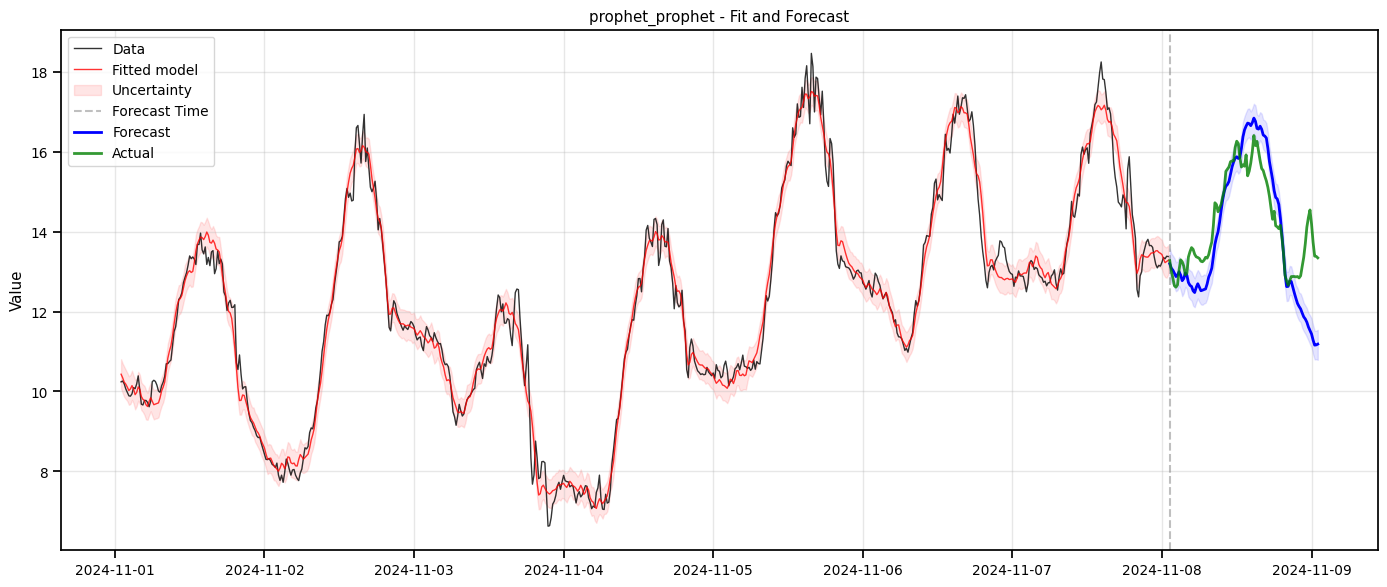

In [5]:
baseline_model.plot(df_test=df_test, window_days=7)

## 4. Standalone NeuralProphet

In [6]:
# Fit standalone NeuralProphet on raw signal
print("Fitting Standalone NeuralProphet...")

# try:
from rubin_oracle import NeuralProphetForecaster, NeuralProphetConfig

# Load config and update forecast horizon
np_config_dict = NeuralProphetConfig.from_yaml(CONFIGS_PATH / "neuralprophet_default.yaml").model_dump()
np_config_dict["epochs"] = 5
np_config_dict["lag_days"] = 1
np_config = NeuralProphetConfig.model_validate(np_config_dict)

print(f"Config: {np_config.name}")
print(f"Lag days: {np_config.lag_days}, N forecast: {np_config.n_forecast}")

np_model = NeuralProphetForecaster(np_config)
np_model.fit(df_train)

# Show in-sample metrics
print("\nStandalone NeuralProphet Metrics:")
for key, val in np_model.metrics_.items():
    print(f"  {key}: {val:.4f}" if isinstance(val, float) else f"  {key}: {val}")

# Forecast
np_fc = np_model.forecast(df_test, np_model.latest_timestamp)
yhat_np = np_fc["yhat"]

rmse_np = np.sqrt(((y_true - yhat_np) ** 2).mean())
print(f"\nStandalone NeuralProphet Forecast RMSE: {rmse_np:.4f}")


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


Fitting Standalone NeuralProphet...
Config: neural_prophet
Lag days: 1, N forecast: 1


Training: |                                                                                                   …

Training: |                                                                                                   …

Predicting: |                                                                                                 …


Standalone NeuralProphet Metrics:
  rmse: 3.6634
  mae: 2.9015
  r2: -0.6132
  n_samples: 6636


Predicting: |                                                                                                 …

ValueError: operands could not be broadcast together with shapes (96,) (24,) 

In [ ]:
np_model.plot(df_test=df_test, window_days=7, lead_time=1)

In [ ]:
# Fit standalone NeuralProphet on raw signal
print("Fitting Standalone NeuralProphet...")

from rubin_oracle import NeuralProphetForecaster, NeuralProphetConfig

# Load config and update forecast horizon
np_reg_config_dict = NeuralProphetConfig.from_yaml(
    CONFIGS_PATH / "neuralprophet_savgol_base.yaml"
).model_dump()
np_reg_config_dict["epochs"] = 50
np_reg_config_dict["lag_days"] = 1
np_reg_config = NeuralProphetConfig.model_validate(np_reg_config_dict)

print(f"Config: {np_reg_config.name}")
print(f"Lag days: {np_reg_config.lag_days}, N forecast: {np_reg_config.n_forecast}")

np_reg_model = NeuralProphetForecaster(np_reg_config)
np_reg_model.fit(df_train)

# Show in-sample metrics
print("\nStandalone NeuralProphet Metrics:")
for key, val in np_reg_model.metrics_.items():
    print(f"  {key}: {val:.4f}" if isinstance(val, float) else f"  {key}: {val}")

# Forecast
np_reg_fc = np_reg_model.forecast(df_test, np_reg_model.latest_timestamp)
yhat_np_reg = np_reg_fc["yhat"]

rmse_np_reg = np.sqrt(((y_true - yhat_np_reg) ** 2).mean())
print(f"\nStandalone NeuralProphet Forecast RMSE: {rmse_np_reg:.4f}")


In [ ]:
np_reg_model._decomposer

In [ ]:
np_reg_model.plot(df_test=df_test, window_days=7, lead_time=-1)

In [50]:
if self._decompose is not None:
    start_date = (self.latest_timestamp).tz_convert(None)
    test_date_min = df_test["ds"].min()
    if test_date_min > self._fit_df["ds"].min():
        history = self._fit_df[self._fit_df["ds"] <= start_date]
        df_test_up = df_test[df_test["ds"] >= start_date]
        df_input = pd.concat([history, df_test_up])


In [86]:
_df_input2 = df[df["ds"] <= self._fit_df['ds'].max() + pd.Timedelta(days=1)]
_df_model2 = self._prepare_df(
    df=_df_input2,
    regressor_cols=self._regressor_cols,
    config=self.config,
    decomposer=self._decomposer,
)

df_model2 = _df_model2[_df_model2["ds"] <= self._fit_df["ds"].max()]

In [87]:
df_model2


,ds,y,y_band_0,y_band_1,y_band_2,y_band_3,y_band_4
0,2024-01-01 00:15:00,12.853100,0.054195,-0.193705,-0.673337,0.003247,14.520469
1,2024-01-01 00:30:00,12.764791,0.152038,-0.229994,-0.684009,0.004629,14.520918
2,2024-01-01 00:45:00,12.777040,0.241507,-0.266127,-0.694342,0.006016,14.521368
3,2024-01-01 01:00:00,12.777202,0.316121,-0.301767,-0.704318,0.007409,14.521820
4,2024-01-01 01:15:00,12.751278,0.372110,-0.336570,-0.713917,0.008807,14.522274
...,...,...,...,...,...,...,...
29951,2024-11-08 00:00:00,13.232422,0.495143,-1.225422,-0.221786,-0.003283,12.725221
29952,2024-11-08 00:15:00,13.351057,0.577769,-1.283949,-0.225112,-0.003181,12.725222
29953,2024-11-08 00:30:00,13.318449,0.630973,-1.335910,-0.228345,-0.003081,12.725223
29954,2024-11-08 00:45:00,13.381951,0.644825,-1.381131,-0.231483,-0.002983,12.725224


<Axes: xlabel='ds'>

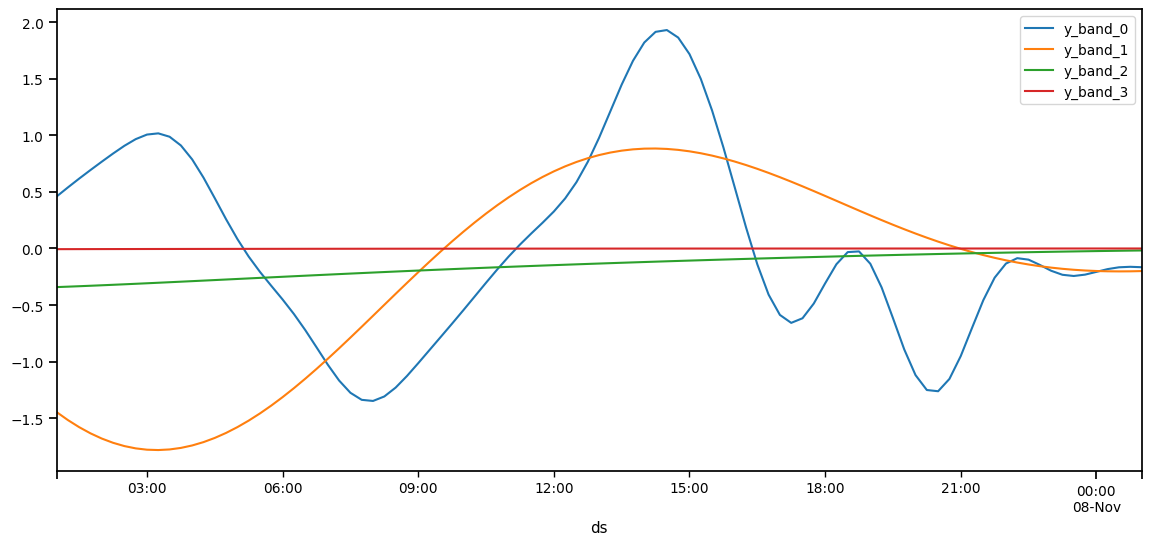

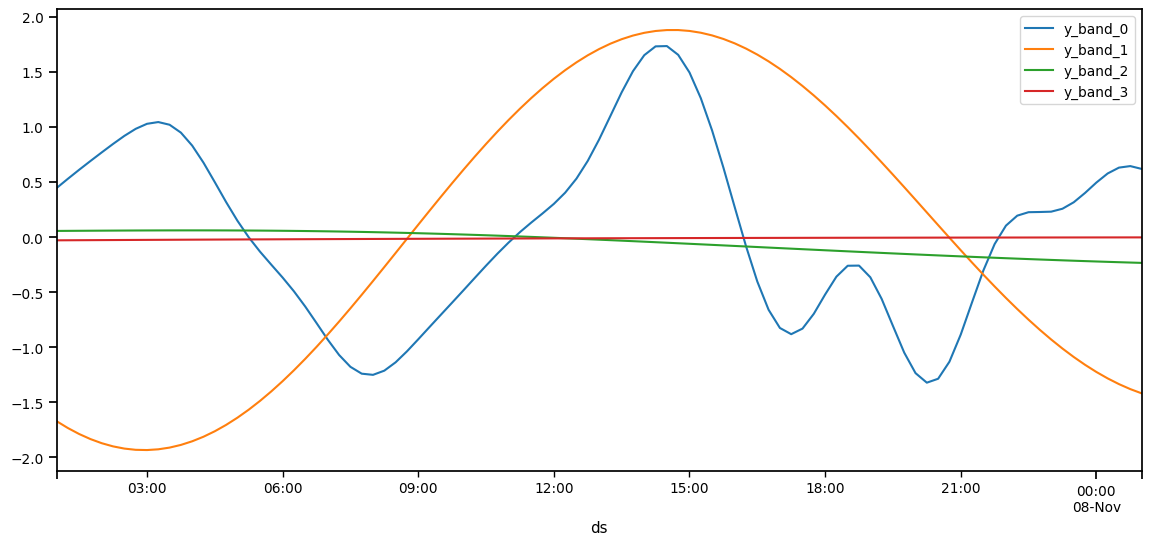

In [90]:
df_input = self._fit_df.tail(97)
df_input.set_index("ds", inplace=True)
df_input[["y_band_0", "y_band_1", "y_band_2", "y_band_3"]].plot()

df_input2 = df_model2.tail(97)
df_input2.set_index("ds", inplace=True)
df_input2[["y_band_0", "y_band_1", "y_band_2", "y_band_3"]].plot()


In [91]:
_forecast = self.predict(df_model2.tail(97), include_history=True, window_days=14)
forecast = self.standardize_output(_forecast)
forecast = forecast.merge(_forecast[["ds", "y"]], on="ds", how="inner")

Predicting: |          | 0/? [00:00<?, ?it/s]

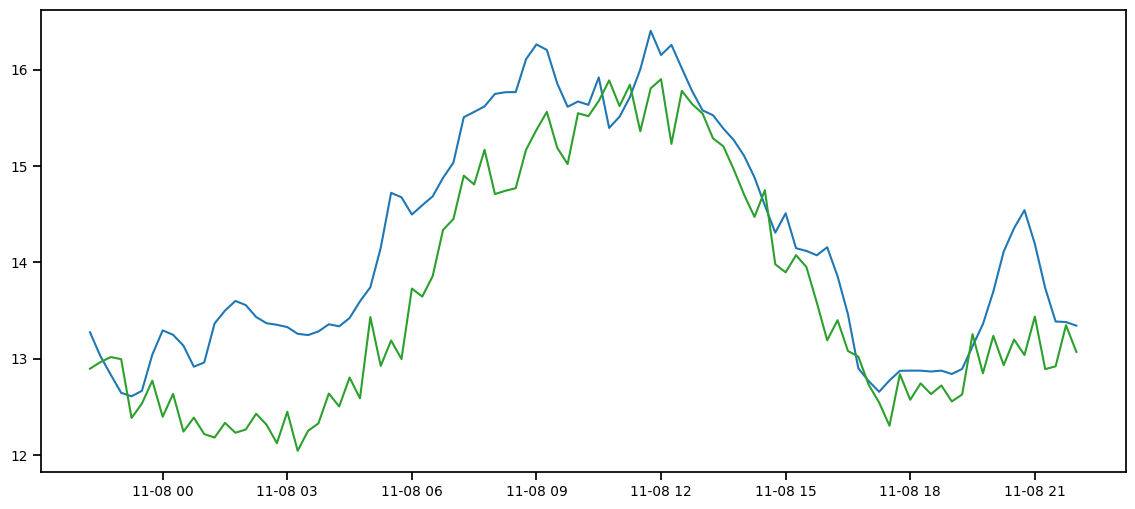

In [ ]:
fc = forecast[forecast["issue_time"] == self.latest_timestamp - pd.Timedelta(hours=3)]

plt.plot(df_test["ds"], df_test["y"])
plt.plot(fc['ds'], fc['y'])
plt.plot(fc["ds"], fc["yhat"])


## 4. Dual Prophet Ensemble (sum + bias)

In [8]:
# Load and fit Dual Prophet with sum combination
print("Fitting Dual Prophet Ensemble (sum + bias)...")

config_dual_sum = EnsembleConfig.from_yaml(CONFIGS_PATH / "ensemble_dual_prophet.yaml")
print(f"\nConfig: {config_dual_sum.name}")
print(f"Components: {[c.name for c in config_dual_sum.components]}")
print(f"Combine method: {config_dual_sum.combine_method}")
print(f"Bias correction: {config_dual_sum.post_processor.bias_correction}")

model_dual_sum = EnsembleForecaster(config_dual_sum)
model_dual_sum.fit(df_train)

# Display ensemble metrics
print("\n" + "=" * 50)
print("ENSEMBLE METRICS (from model.metrics_)")
print("=" * 50)
print(f"Overall RMSE: {model_dual_sum.metrics_['rmse']:.4f}")
print(f"Overall MAE:  {model_dual_sum.metrics_['mae']:.4f}")
print(f"Overall R²:   {model_dual_sum.metrics_['r2']:.4f}")
print(f"Samples:      {model_dual_sum.metrics_['n_samples']}")
print("\nComponent metrics:")
for name, m in model_dual_sum.metrics_["components"].items():
    print(f"  {name}: RMSE={m['rmse']:.4f}, MAE={m['mae']:.4f}, R²={m['r2']:.4f}")

# Predict
fc_dual_sum = model_dual_sum.predict(df_train.tail(60 * STEPS_PER_DAY), periods=FORECAST_HORIZON)
yhat_dual_sum = fc_dual_sum["yhat"].values

rmse_dual_sum = np.sqrt(((y_true - yhat_dual_sum) ** 2).mean())
print(f"\nDual Prophet (sum) Forecast RMSE: {rmse_dual_sum:.4f}")

Fitting Dual Prophet Ensemble (sum + bias)...

Config: ensemble
Components: ['high_freq', 'low_freq']
Combine method: sum
Bias correction: True

Fitting EnsembleForecaster with 2 components...
DECOMPOSITION SIGNAL RECOVERY
Original signal variance:    33.3839
Residual variance:           0.043689
Variance recovered:          99.87%
Mean bias:                   0.0004°C
Max absolute residual:       2.6643°C
------------------------------------------------------------
  y_band_0: variance=0.7513 (2.3%)
  y_band_1: variance=2.7689 (8.3%)
  y_band_2: variance=4.1397 (12.4%)
  y_band_3: variance=3.5439 (10.6%)
  y_band_4: variance=20.1044 (60.2%)

[1/2] Fitting component: high_freq
  Model type: prophet
  Bands: [0, 1]
  Lag days: 7
  Training samples: 29952

[2/2] Fitting component: low_freq
  Model type: prophet
  Bands: [2, 3, 4]
  Lag days: 7
  Downsampled to: 6h
  Training samples: 1249

ENSEMBLE FIT METRICS
Overall RMSE: 3.3716
Overall MAE:  2.6439
Overall R²:   0.6595
---------------

TypeError: ProphetForecaster.forecast() got multiple values for argument 'periods'

### 4.1 Ensemble Plots

Use `model.plot()` for combined ensemble view and `model.plot_components()` for per-component panels.

In [14]:
# Plot ensemble fit and forecast (combined view)
fig, ax = model_dual_sum.plot(
    df_train, window_days=7, title="Dual Prophet Ensemble - Combined Fit and Forecast"
)
plt.show()

TypeError: ProphetForecaster.forecast() got multiple values for argument 'periods'

In [ ]:
# Plot individual components (high_freq and low_freq)
fig, axes = model_dual_sum.plot_components(df_train, window_days=7)
plt.show()

In [ ]:
# Access individual component models
print("Component model access:")
print(f"  model.get_component_names() = {model_dual_sum.get_component_names()}")
print(f"  model.components.keys() = {list(model_dual_sum.components.keys())}")
print(f"  model.high_freq_model = {type(model_dual_sum.high_freq_model).__name__}")
print(f"  model.low_freq_model = {type(model_dual_sum.low_freq_model).__name__}")

# Access high_freq model metrics
print("\nHigh-freq component metrics:")
hf_model = model_dual_sum.high_freq_model
for key, val in hf_model.metrics_.items():
    print(f"  {key}: {val:.4f}" if isinstance(val, float) else f"  {key}: {val}")

# Plot individual component using Prophet's plot method
print("\nPlotting high_freq component:")
fig, ax = hf_model.plot(window_days=7, title="High-freq Component (Prophet)")
plt.show()

## 5. Dual Prophet Ensemble (weighted)

In [ ]:
# Load and fit Dual Prophet with weighted combination
print("Fitting Dual Prophet Ensemble (weighted)...")

config_weighted = EnsembleConfig.from_yaml(CONFIGS_PATH / "ensemble_dual_prophet.yaml")
# Modify to use weighted combination
config_weighted.combine_method = "weighted"
config_weighted.component_weights = [0.4, 0.6]  # 40% high-freq, 60% low-freq
print(f"\nConfig: {config_weighted.name}")
print(f"Combine method: {config_weighted.combine_method}")
print(f"Component weights: {config_weighted.component_weights}")

model_weighted = EnsembleForecaster(config_weighted)
model_weighted.fit(df_train)

# Display metrics
print("\nWeighted Ensemble Metrics:")
print(f"  RMSE: {model_weighted.metrics_['rmse']:.4f}")
print(f"  MAE:  {model_weighted.metrics_['mae']:.4f}")
print(f"  R²:   {model_weighted.metrics_['r2']:.4f}")

# Predict
fc_weighted = model_weighted.predict(df_train.tail(60 * STEPS_PER_DAY), periods=FORECAST_HORIZON)
yhat_weighted = fc_weighted["yhat"].values

rmse_weighted = np.sqrt(((y_true - yhat_weighted) ** 2).mean())
print(f"\nWeighted Ensemble Forecast RMSE: {rmse_weighted:.4f}")

## 6. Dual NeuralProphet Ensemble

In [ ]:
# Load and fit Dual NeuralProphet
print("Fitting Dual NeuralProphet Ensemble...")

try:
    config_dual_np = EnsembleConfig.from_yaml(CONFIGS_PATH / "ensemble_dual_neuralprophet.yaml")
    print(f"\nConfig: {config_dual_np.name}")
    print(f"Components: {[c.name for c in config_dual_np.components]}")

    model_dual_np = EnsembleForecaster(config_dual_np)
    model_dual_np.fit(df_train)

    # Display metrics
    print("\nDual NeuralProphet Metrics:")
    print(f"  RMSE: {model_dual_np.metrics_['rmse']:.4f}")
    print(f"  MAE:  {model_dual_np.metrics_['mae']:.4f}")
    print(f"  R²:   {model_dual_np.metrics_['r2']:.4f}")

    # Predict
    fc_dual_np = model_dual_np.predict(df_train.tail(60 * STEPS_PER_DAY), periods=FORECAST_HORIZON)
    yhat_dual_np = fc_dual_np["yhat"].values

    rmse_dual_np = np.sqrt(((y_true - yhat_dual_np) ** 2).mean())
    print(f"\nDual NeuralProphet Forecast RMSE: {rmse_dual_np:.4f}")

except Exception as e:
    print(f"NeuralProphet not available or error: {e}")
    yhat_dual_np = None
    rmse_dual_np = None
    model_dual_np = None

In [ ]:
# Plot Dual NeuralProphet ensemble (if available)
if model_dual_np is not None:
    fig, ax = model_dual_np.plot(
        df_train, window_days=7, title="Dual NeuralProphet Ensemble - Fit and Forecast"
    )
    plt.show()

## 7. Forecast Comparison Plot

In [ ]:
# Visualize all forecasts
fig, ax = plt.subplots(figsize=(16, 7))

hours = np.arange(FORECAST_HORIZON) / STEPS_PER_HOUR

# Actual
ax.plot(hours, y_true, "-", color=COLORS["actual"], lw=2.5, label="Actual")

# Baseline Prophet
ax.plot(
    hours,
    yhat_baseline_bias,
    "--",
    color=COLORS["baseline"],
    lw=1.5,
    label=f"Baseline Prophet (RMSE={rmse_baseline:.3f})",
)

# Standalone NeuralProphet
if yhat_np is not None:
    ax.plot(
        hours,
        yhat_np,
        "-",
        color=COLORS["np_lagged"],
        lw=1.5,
        label=f"Standalone NeuralProphet (RMSE={rmse_np:.3f})",
    )

# Dual Prophet (sum)
ax.plot(
    hours,
    yhat_dual_sum,
    "-",
    color=COLORS["dual_sum"],
    lw=1.5,
    label=f"Dual Prophet sum (RMSE={rmse_dual_sum:.3f})",
)

# Dual Prophet (weighted)
ax.plot(
    hours,
    yhat_weighted,
    "-",
    color=COLORS["dual_reconcile"],
    lw=1.5,
    label=f"Dual Prophet weighted (RMSE={rmse_weighted:.3f})",
)

# Dual NeuralProphet
if yhat_dual_np is not None:
    ax.plot(
        hours,
        yhat_dual_np,
        "-",
        color=COLORS["dual_np"],
        lw=1.5,
        label=f"Dual NeuralProphet (RMSE={rmse_dual_np:.3f})",
    )

ax.set_xlabel("Forecast Horizon (hours)", fontsize=12)
ax.set_ylabel("Temperature (°C)", fontsize=12)
ax.set_title("24h Forecast Comparison: All Models", fontsize=14)
ax.legend(fontsize=10, loc="best")
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 24)

plt.tight_layout()
plt.show()

## 8. RMSE by Lead Time

In [15]:
# Compute RMSE at different lead times
def rmse_at_step(y_true, yhat, step):
    return np.sqrt((y_true[step - 1] - yhat[step - 1]) ** 2)


lead_times_h = [2, 4, 6, 8, 12, 16, 20, 24]

results = {"Lead Time": lead_times_h}
results["Baseline Prophet"] = [
    rmse_at_step(y_true, yhat_baseline_bias, h * STEPS_PER_HOUR) for h in lead_times_h
]

if yhat_np is not None:
    results["Standalone NP"] = [
        rmse_at_step(y_true, yhat_np, h * STEPS_PER_HOUR) for h in lead_times_h
    ]

results["Dual Sum"] = [
    rmse_at_step(y_true, yhat_dual_sum, h * STEPS_PER_HOUR) for h in lead_times_h
]
results["Dual Weighted"] = [
    rmse_at_step(y_true, yhat_weighted, h * STEPS_PER_HOUR) for h in lead_times_h
]

if yhat_dual_np is not None:
    results["Dual NP"] = [
        rmse_at_step(y_true, yhat_dual_np, h * STEPS_PER_HOUR) for h in lead_times_h
    ]

df_results = pd.DataFrame(results)
print("RMSE at Key Lead Times:")
print(df_results.to_string(index=False))

KeyError: 7

In [ ]:
# Plot RMSE by lead time
fig, ax = plt.subplots(figsize=(12, 5))


# Compute rolling RMSE
def rolling_rmse(y_true, yhat, window=4):
    rmse = []
    for i in range(len(y_true)):
        start = max(0, i - window + 1)
        rmse.append(np.sqrt(np.mean((y_true[start : i + 1] - yhat[start : i + 1]) ** 2)))
    return np.array(rmse)


hours = np.arange(FORECAST_HORIZON) / STEPS_PER_HOUR

ax.plot(
    hours,
    rolling_rmse(y_true, yhat_baseline_bias),
    "-",
    color=COLORS["baseline"],
    lw=2,
    label="Baseline Prophet",
)

if yhat_np is not None:
    ax.plot(
        hours,
        rolling_rmse(y_true, yhat_np),
        "-",
        color=COLORS["np_lagged"],
        lw=2,
        label="Standalone NP",
    )

ax.plot(
    hours,
    rolling_rmse(y_true, yhat_dual_sum),
    "-",
    color=COLORS["dual_sum"],
    lw=2,
    label="Dual Sum",
)
ax.plot(
    hours,
    rolling_rmse(y_true, yhat_weighted),
    "-",
    color=COLORS["dual_reconcile"],
    lw=2,
    label="Dual Weighted",
)

if yhat_dual_np is not None:
    ax.plot(
        hours,
        rolling_rmse(y_true, yhat_dual_np),
        "-",
        color=COLORS["dual_np"],
        lw=2,
        label="Dual NP",
    )

ax.axhline(y=1.0, color="gray", linestyle="--", alpha=0.5, label="1°C threshold")
ax.set_xlabel("Forecast Horizon (hours)", fontsize=12)
ax.set_ylabel("Rolling RMSE (°C)", fontsize=12)
ax.set_title("Rolling RMSE by Lead Time", fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 24)

plt.tight_layout()
plt.show()

## 9. Decomposition Visualization

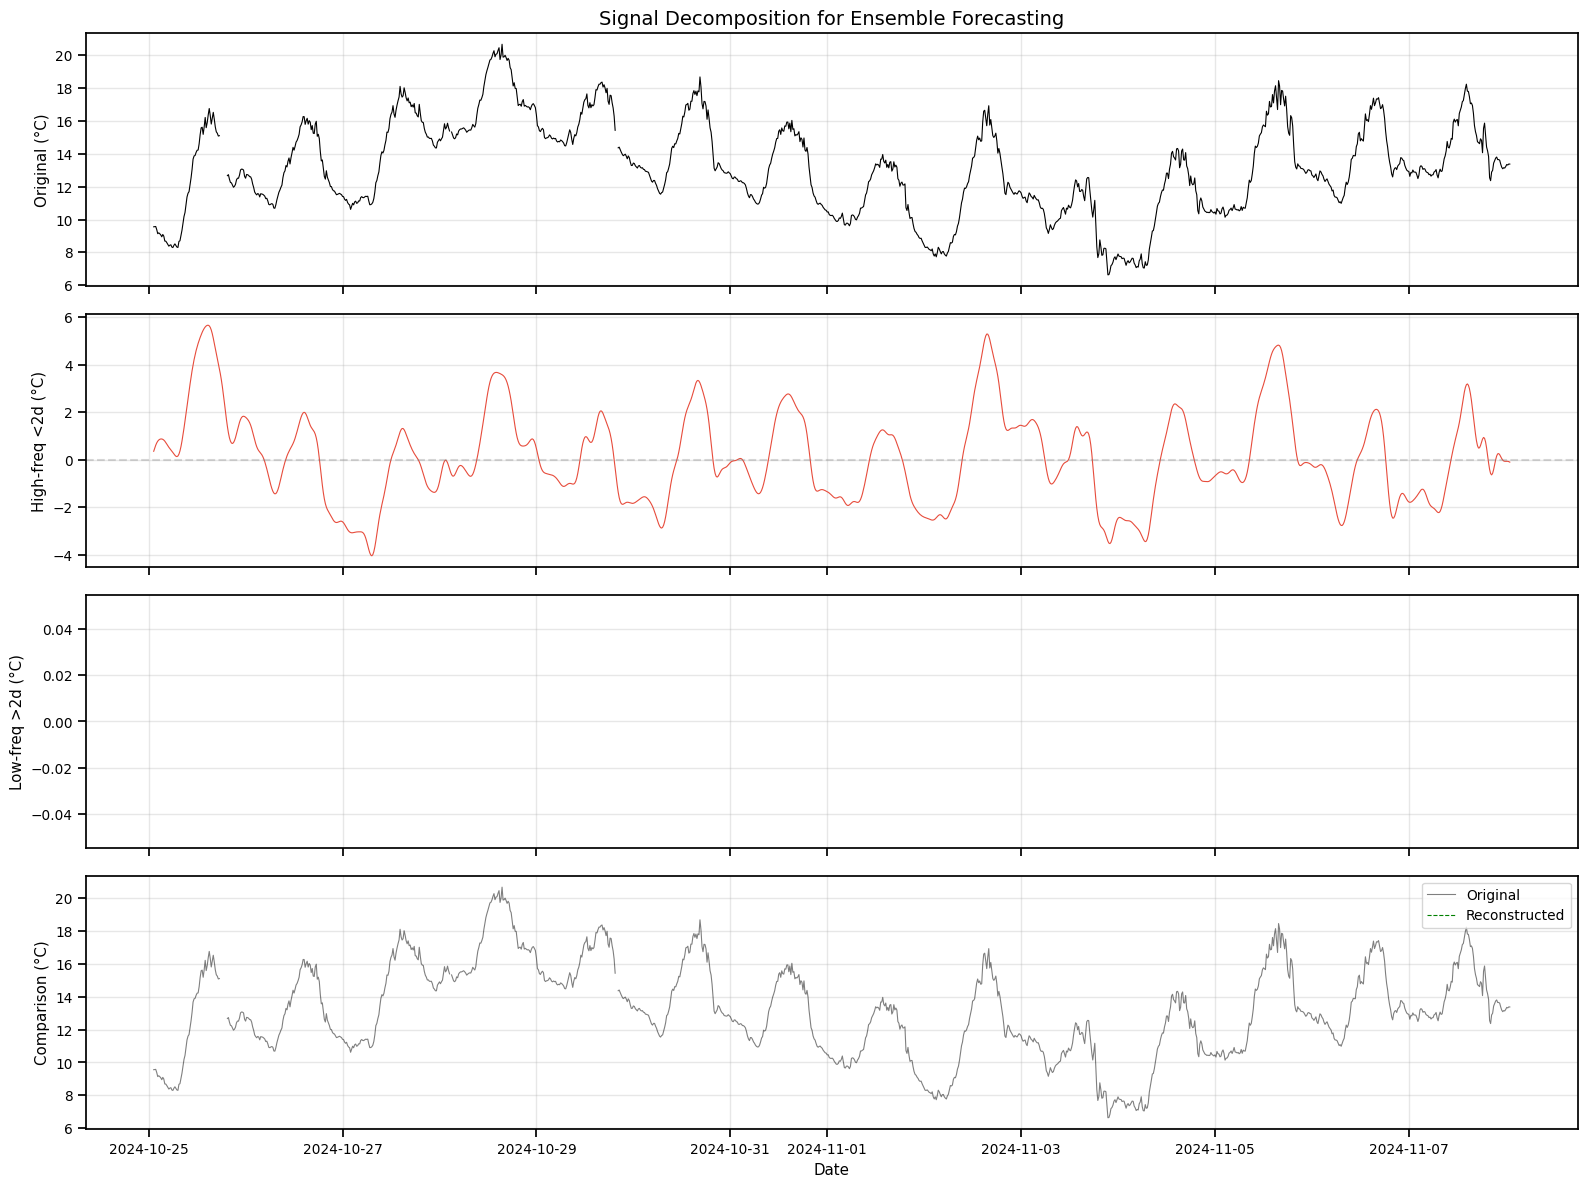


Variance Recovery: nan%
High-freq variance: 3.7918 (47.4%)
Low-freq variance: nan (nan%)


In [16]:
# Show signal decomposition
decomposer = BandpassDecomposer(
    freq=STEPS_PER_DAY,
    period_pairs=[
        (0.10, 0.70),  # Band 0: Sub-daily
        (0.70, 4.00),  # Band 1: Daily
        (4.00, 11.00),  # Band 2: Weekly
        (11.00, 25.00),  # Band 3: Bi-weekly
        (25.00, 60.00),  # Band 4: Monthly
    ],
    filter_type="savgol",
    savgol_polyorder=3,
    edge_method="reflect",
    verbose=False,
)

# Decompose last 14 days for visualization
df_viz = df_train.tail(14 * STEPS_PER_DAY).copy()
df_decomposed = decomposer.decompose(df_viz)

# Plot
fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True)

# Original signal
axes[0].plot(df_decomposed["ds"], df_decomposed["y"], "k", lw=0.8)
axes[0].set_ylabel("Original (°C)")
axes[0].set_title("Signal Decomposition for Ensemble Forecasting", fontsize=14)

# High-freq (bands 0-1)
high_freq = df_decomposed["y_band_0"] + df_decomposed["y_band_1"]
axes[1].plot(df_decomposed["ds"], high_freq, color="#e74c3c", lw=0.8)
axes[1].set_ylabel("High-freq <2d (°C)")
axes[1].axhline(0, color="gray", linestyle="--", alpha=0.3)

# Low-freq (bands 2-4)
low_freq = df_decomposed["y_band_2"] + df_decomposed["y_band_3"] + df_decomposed["y_band_4"]
axes[2].plot(df_decomposed["ds"], low_freq, color="#3498db", lw=0.8)
axes[2].set_ylabel("Low-freq >2d (°C)")

# Reconstructed
reconstructed = high_freq + low_freq
axes[3].plot(df_decomposed["ds"], df_decomposed["y"], "k", lw=0.8, alpha=0.5, label="Original")
axes[3].plot(df_decomposed["ds"], reconstructed, "g--", lw=0.8, label="Reconstructed")
axes[3].set_ylabel("Comparison (°C)")
axes[3].set_xlabel("Date")
axes[3].legend(loc="upper right")

for ax in axes:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Variance recovery
var_original = df_decomposed["y"].var()
var_reconstructed = reconstructed.var()
residual = df_decomposed["y"] - reconstructed
var_residual = residual.var()
recovery = 1 - var_residual / var_original

print(f"\nVariance Recovery: {recovery * 100:.2f}%")
print(f"High-freq variance: {high_freq.var():.4f} ({high_freq.var() / var_original * 100:.1f}%)")
print(f"Low-freq variance: {low_freq.var():.4f} ({low_freq.var() / var_original * 100:.1f}%)")

## 10. Summary

In [ ]:
# Summary table
print("=" * 70)
print("SUMMARY: 24h Forecast RMSE")
print("=" * 70)

summary = {
    "Model": ["Baseline Prophet", "Dual Prophet (sum)", "Dual Prophet (weighted)"],
    "RMSE": [rmse_baseline, rmse_dual_sum, rmse_weighted],
    "In-sample R²": [
        baseline_model.metrics_["r2"],
        model_dual_sum.metrics_["r2"],
        model_weighted.metrics_["r2"],
    ],
}

if rmse_np is not None:
    summary["Model"].insert(1, "Standalone NeuralProphet")
    summary["RMSE"].insert(1, rmse_np)
    summary["In-sample R²"].insert(1, np_model.metrics_["r2"])

if rmse_dual_np is not None:
    summary["Model"].append("Dual NeuralProphet")
    summary["RMSE"].append(rmse_dual_np)
    summary["In-sample R²"].append(model_dual_np.metrics_["r2"])

df_summary = pd.DataFrame(summary)
df_summary["Improvement vs Baseline"] = (rmse_baseline - df_summary["RMSE"]) / rmse_baseline * 100
df_summary["Improvement vs Baseline"] = df_summary["Improvement vs Baseline"].apply(
    lambda x: f"{x:+.1f}%"
)
df_summary["In-sample R²"] = df_summary["In-sample R²"].apply(lambda x: f"{x:.4f}")

print(df_summary.to_string(index=False))

print("\n" + "=" * 70)
best_idx = pd.to_numeric(df_summary["RMSE"], errors="coerce").idxmin()
best_model = df_summary.loc[best_idx, "Model"]
best_rmse = df_summary.loc[best_idx, "RMSE"]
print(f"BEST MODEL: {best_model} (RMSE: {best_rmse:.4f})")
print("=" * 70)

# Show all model metrics in a nice table
print("\n" + "=" * 70)
print("IN-SAMPLE FIT METRICS (model.metrics_)")
print("=" * 70)
print(f"{'Model':<30} {'RMSE':>10} {'MAE':>10} {'R²':>10}")
print("-" * 70)
print(
    f"{'Baseline Prophet':<30} {baseline_model.metrics_['rmse']:>10.4f} {baseline_model.metrics_['mae']:>10.4f} {baseline_model.metrics_['r2']:>10.4f}"
)

if np_model is not None:
    print(
        f"{'Standalone NeuralProphet':<30} {np_model.metrics_['rmse']:>10.4f} {np_model.metrics_['mae']:>10.4f} {np_model.metrics_['r2']:>10.4f}"
    )

print(
    f"{'Dual Prophet (sum)':<30} {model_dual_sum.metrics_['rmse']:>10.4f} {model_dual_sum.metrics_['mae']:>10.4f} {model_dual_sum.metrics_['r2']:>10.4f}"
)
print(
    f"{'Dual Prophet (weighted)':<30} {model_weighted.metrics_['rmse']:>10.4f} {model_weighted.metrics_['mae']:>10.4f} {model_weighted.metrics_['r2']:>10.4f}"
)

if model_dual_np is not None:
    print(
        f"{'Dual NeuralProphet':<30} {model_dual_np.metrics_['rmse']:>10.4f} {model_dual_np.metrics_['mae']:>10.4f} {model_dual_np.metrics_['r2']:>10.4f}"
    )
print("=" * 70)

## 11. Save/Load Model Demo

In [ ]:
# Demonstrate save/load functionality
import tempfile


with tempfile.TemporaryDirectory() as tmpdir:
    save_path = Path(tmpdir) / "ensemble_model"

    # Save
    model_dual_sum.save(save_path)
    print(f"Model saved to: {save_path}")
    print(f"Contents: {list(save_path.iterdir())}")

    # Load
    loaded_model = EnsembleForecaster.load(save_path)
    print("\nModel loaded successfully!")
    print(f"Components: {[c.name for c, _ in loaded_model._components]}")

    # Verify prediction
    fc_loaded = loaded_model.predict(df_train.tail(60 * STEPS_PER_DAY), periods=FORECAST_HORIZON)
    print(
        f"\nLoaded model prediction matches: {np.allclose(fc_loaded['yhat'].values, yhat_dual_sum)}"
    )

## 12. Conclusions

Key findings from this exploration:

1. **Dual Prophet with frequency decomposition** significantly outperforms baseline Prophet
2. **Weighted combination** of frequency bands can be optimized to improve forecasts
3. **Bias correction** is important for Prophet models (they don't weight recent observations)
4. **NeuralProphet** may not need bias correction due to autoregressive components

### New Features Demonstrated:

- **`model.metrics_`**: Access in-sample fit metrics (RMSE, MAE, R²) for any fitted model
- **`model.plot()`**: Visualize training data, fitted model, and forecast in one call
- **`model.plot_components()`**: Panel view of each ensemble component
- **`model.get_component_names()`**: List component names
- **`model.high_freq_model`**: Direct access to component models via attribute

### Ensemble Combination Methods:

- **`sum`**: Simple sum of component forecasts (default)
- **`weighted`**: Weighted combination with user-specified weights that sum to 1.0

### Recommendations:
- For short-term (0-4h): Dual Prophet/NeuralProphet with high-freq focus
- For long-term (12-24h): Dual models capture weekly/monthly patterns better
- Use `combine_method='weighted'` to tune component importance based on your data characteristics